# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from collections import OrderedDict, Counter
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('Shape: {}\n'.format(azdias.shape))
print(azdias.head(2))

Shape: (891221, 85)

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...  PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3  ...         NaN         NaN   
1                      4                 5  ...         2.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  

[2 rows x 85 columns]


In [4]:
print('Shape: {}\n'.format(feat_info.shape))
print(feat_info.head())

Shape: (85, 4)

              attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
init_nan_count = azdias.isna().sum().sum()

In [6]:
def missing_value_code_to_list(code):
    
    '''
     This function converts a missing_value_code from the feat_info 
     dataframe from string to list format.
     
     INPUT: str - The missing_value_code as a string.
     
     OUTPUt: list - the missing_value code as a list.
    '''
    
    code_as_list = code[1:-1].split(',')
    
    for i in range(len(code_as_list)):
        
        try:
            code_as_list[i] = int(code_as_list[i])
        except:
            continue
    
    return code_as_list

In [7]:
for col in azdias.columns:
    
    missing_value_code = feat_info[feat_info.attribute == col]['missing_or_unknown'].item()
    missing_value_code = missing_value_code_to_list(missing_value_code)

    azdias.loc[azdias[col].isin(missing_value_code), col] = np.nan

In [8]:
final_nan_count = azdias.isna().sum().sum()
percent_increase = ((final_nan_count - init_nan_count) / init_nan_count)*100
percent_unknown = (final_nan_count / (azdias.shape[0]*azdias.shape[1]))*100

print('Total missing data values before cleaning: {}'.format(init_nan_count))
print('Total missing data values after cleaning: {}'.format(final_nan_count))
print('Percent increase after cleaning: {}%'.format(percent_increase))
print('Percent of entries that are unknonw: {}%'.format(percent_unknown))

Total missing data values before cleaning: 4896838
Total missing data values after cleaning: 8373929
Percent increase after cleaning: 71.00686197909754%
Percent of entries that are unknonw: 11.05413940702765%


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
nan_col_counts = azdias.isna().sum(axis = 0)

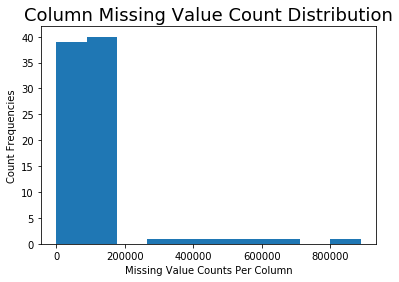

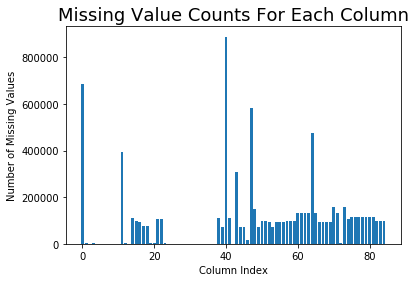

In [10]:
plt.figure();
plt.hist(nan_col_counts);
plt.title('Column Missing Value Count Distribution', fontsize = 18);
plt.xlabel('Missing Value Counts Per Column');
plt.ylabel('Count Frequencies');

plt.figure();
plt.bar(range(azdias.shape[1]), nan_col_counts);
plt.title('Missing Value Counts For Each Column', fontsize = 18);
plt.xlabel('Column Index');
plt.ylabel('Number of Missing Values');

In [11]:
# Remove outlier columns

outliers = []
complete_cols = []

for col in azdias.columns:
    
    if nan_col_counts[col] > int(2e5):
        outliers.append(col)
    elif nan_col_counts[col] == 0:
        complete_cols.append(col)

azdias_reduced = azdias.drop(outliers, axis = 1)

In [12]:
print('Outlier Columns:')
feat_info[feat_info.attribute.isin(outliers)]

Outlier Columns:


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
11,GEBURTSJAHR,person,numeric,[0]
40,TITEL_KZ,person,categorical,"[-1,0]"
43,ALTER_HH,household,interval,[0]
47,KK_KUNDENTYP,household,categorical,[-1]
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"


In [13]:
nan_col_counts_reduced = azdias_reduced.isna().sum(axis = 0)

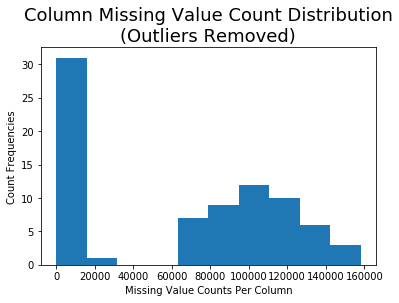

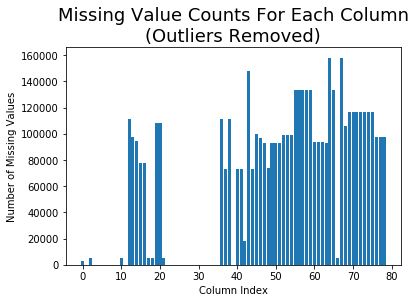

In [14]:
plt.figure();
plt.hist(nan_col_counts_reduced);
plt.title('Column Missing Value Count Distribution\n(Outliers Removed)', fontsize = 18);
plt.xlabel('Missing Value Counts Per Column');
plt.ylabel('Count Frequencies');

plt.figure();
plt.bar(range(azdias_reduced.shape[1]), nan_col_counts_reduced);
plt.title('Missing Value Counts For Each Column\n(Outliers Removed)', fontsize = 18);
plt.xlabel('Column Index');
plt.ylabel('Number of Missing Values');

In [15]:
# Investigate patterns in the amount of missing data in each column.

cols = azdias_reduced.drop(complete_cols, axis = 1).columns
n_cols = len(cols)
num_strong_corr = 0

for i in range(n_cols):
    
    for j in range(i, n_cols):
        
        if i == j:
            continue
        
        col_corr = np.corrcoef(azdias[cols[i]].isna().astype(int), 
                               azdias[cols[j]].isna().astype(int))[0][1]
        
        if col_corr >= 0.5:
            num_strong_corr += 1

combinations = math.factorial(n_cols) / (2*math.factorial(n_cols - 2))

print('Number of column pairs that are highly correlated: {}'.format(num_strong_corr))
print('Percentage of pairs of remaining columns that are not ' + \
      'complete and highly correlated: {}%'.format(100*(num_strong_corr / combinations)))

Number of column pairs that are highly correlated: 957
Percentage of pairs of remaining columns that are not complete and highly correlated: 64.44444444444444%


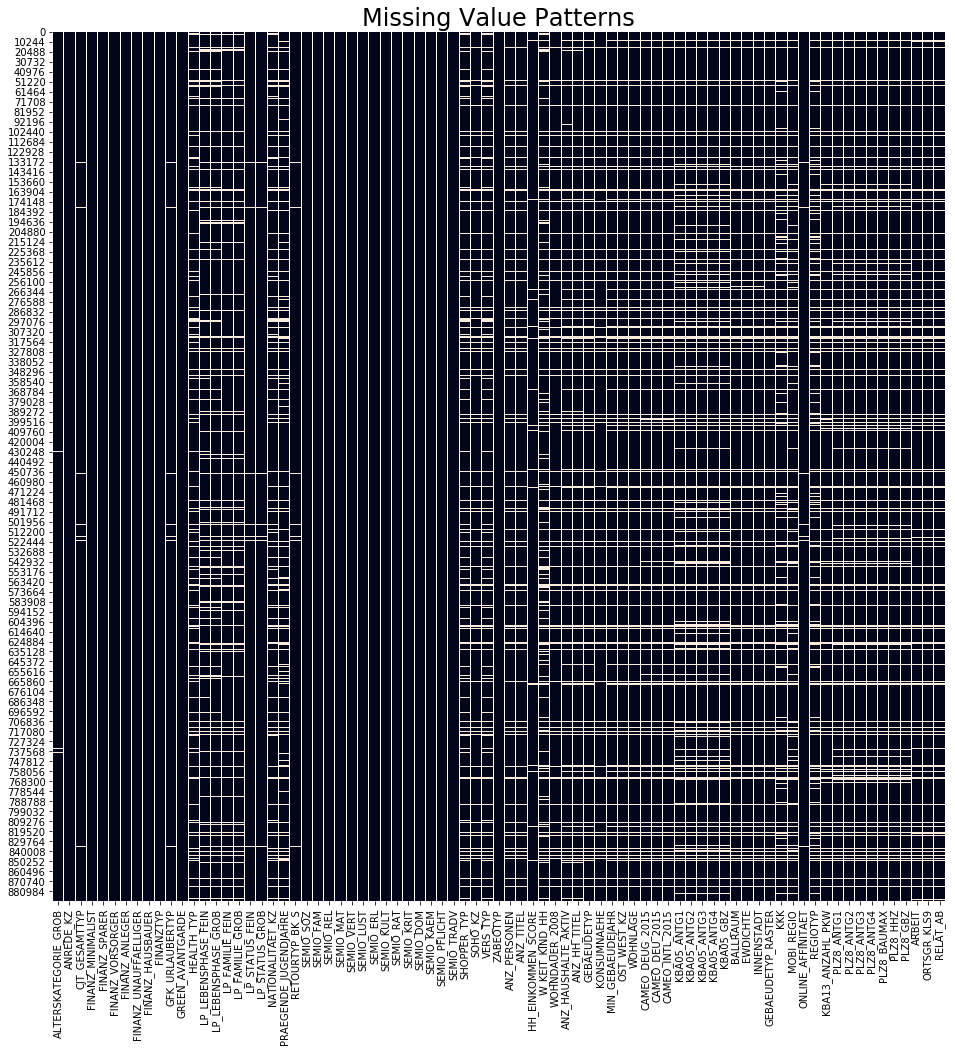

In [153]:
plt.figure(figsize = (16, 16));
sns.heatmap(azdias.drop(outliers, axis = 1).isnull(), cbar=False);
plt.title('Missing Value Patterns', fontsize = 24);

In [16]:
azdias = azdias_reduced
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

The bar graph and histogram for the non-reduced data set indicate that the majority of the columns contain less than 200,000 missing values while the columns AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, and KBA05_BAUMAX contained significantly more missing values.  The information contained in AGER_TYP, GEBURTSJAHR, ALTER_HH, and TITLE_KZ pertain mainly to age and academic level while that contained in KK_KUNDENTYP and KBA05_BAUMAX pertain to consumer patterns and household size. These six columns were removed from the reduced data set.  

For the remaining columns, the heatmap suggests that the missing values within each column are distributed irregularily but the rows at which the missing values occur are significantly correlated between the columns. It was calculated that 64% of the column pairs were highly correlated ($R \geq 0.5$) in reguard to missing value row locations. This suggests that if there is a deficit of information about a given feature for an invidual, there is a deficit of information about that individual in general.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [17]:
# How much data is missing in each row of the dataset?
nan_row_counts = azdias.isna().sum(axis = 1)

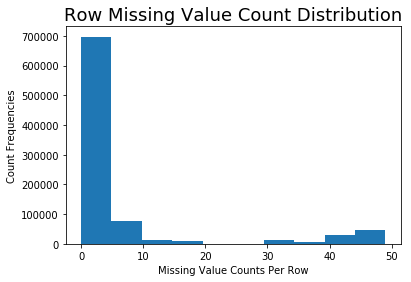

In [18]:
plt.figure();
plt.hist(nan_row_counts);
plt.title('Row Missing Value Count Distribution', fontsize = 18);
plt.xlabel('Missing Value Counts Per Row');
plt.ylabel('Count Frequencies');

In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_high_mv = azdias[nan_row_counts > 10]
azdias_low_mv = azdias[nan_row_counts <= 10]

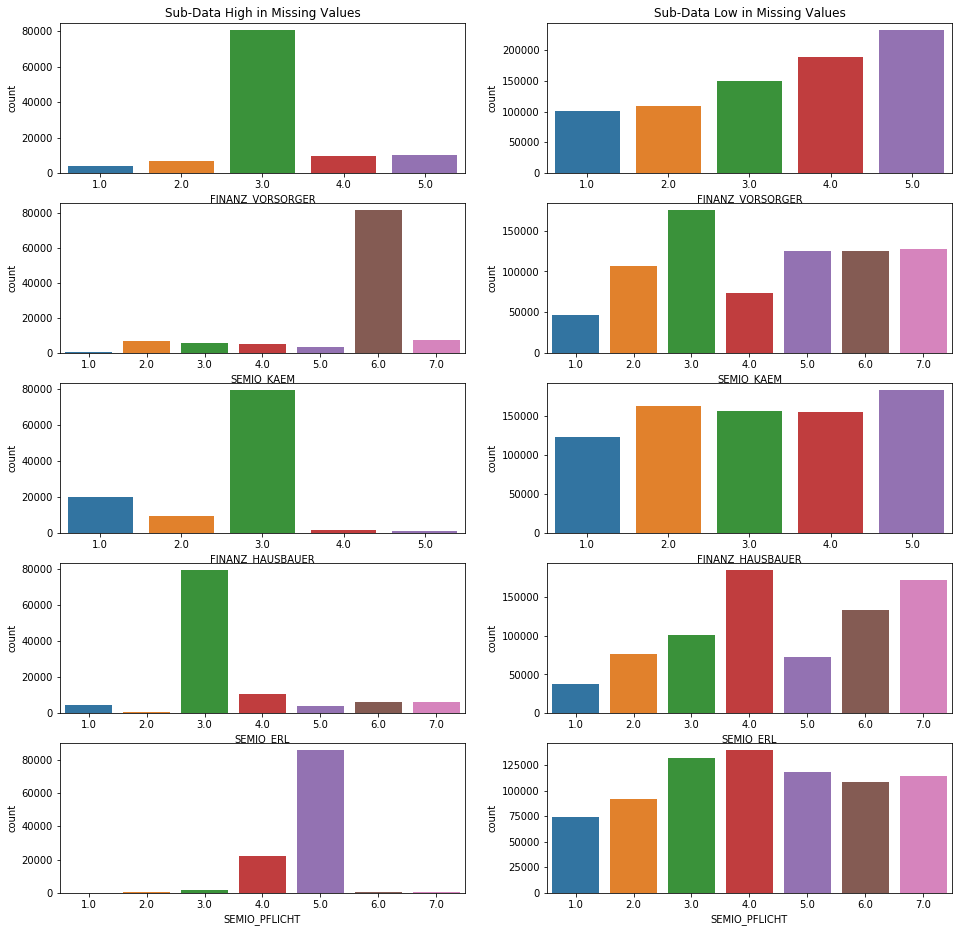

In [20]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

cols = np.random.choice(complete_cols, size = (5,))
plot_index = 1
plt.figure(figsize = (16, 16))

for col in cols:
    
    plt.subplot(5, 2, plot_index)
    sns.countplot(azdias_high_mv[col])
    
    if plot_index == 1:
        plt.title('Sub-Data High in Missing Values')
    
    plt.subplot(5, 2, plot_index + 1)
    sns.countplot(azdias_low_mv[col])
    
    if plot_index == 1:
        plt.title('Sub-Data Low in Missing Values')
    
    plot_index += 2

In [21]:
azdias = azdias_low_mv
azdias.shape

(780153, 79)

#### Discussion 1.1.3: Assess Missing Data in Each Row
The row-missing-value histogram shows that most rows contain less than 10 missing features hence the data was split such that the high-missing-feature subset contained rows missing more than 10 features while the low-missing-feature subset contained rows missing less than or equal to 10 features.  Furthermore, the distributions of complete columns differ significantly between the data in the two subsets.  For the high-missing-features data, a single value has a disproportionaltly high frequency while the value frequencies for the low-missing-feature data are evenly distributed across the range of feature values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
# How many features are there of each data type?
feat_type_counts = feat_info.type.value_counts()
feat_type_counts

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cat_feats = feat_info[(feat_info.type == 'categorical') & \
                       feat_info.attribute.isin(azdias.columns)]['attribute']

print('Categorical Features: {}'.format(len(cat_feats)))
for feat in cat_feats:
    print('\t' + feat)

Categorical Features: 18
	ANREDE_KZ
	CJT_GESAMTTYP
	FINANZTYP
	GFK_URLAUBERTYP
	GREEN_AVANTGARDE
	LP_FAMILIE_FEIN
	LP_FAMILIE_GROB
	LP_STATUS_FEIN
	LP_STATUS_GROB
	NATIONALITAET_KZ
	SHOPPER_TYP
	SOHO_KZ
	VERS_TYP
	ZABEOTYP
	GEBAEUDETYP
	OST_WEST_KZ
	CAMEO_DEUG_2015
	CAMEO_DEU_2015


In [24]:
unique_val_counts = azdias[cat_feats].nunique()
binary_cat_feats = unique_val_counts[unique_val_counts == 2].index
multi_level_cat_feats = unique_val_counts[unique_val_counts > 2].index

print('Binary Categorical Features: {}'.format(len(binary_cat_feats)))
for feat in binary_cat_feats:
    print('\t' + feat)

print('\nMulit-level Categorical Features: {}'.format(len(multi_level_cat_feats)))
for feat in multi_level_cat_feats:
    print('\t' + feat)

Binary Categorical Features: 5
	ANREDE_KZ
	GREEN_AVANTGARDE
	SOHO_KZ
	VERS_TYP
	OST_WEST_KZ

Mulit-level Categorical Features: 13
	CJT_GESAMTTYP
	FINANZTYP
	GFK_URLAUBERTYP
	LP_FAMILIE_FEIN
	LP_FAMILIE_GROB
	LP_STATUS_FEIN
	LP_STATUS_GROB
	NATIONALITAET_KZ
	SHOPPER_TYP
	ZABEOTYP
	GEBAEUDETYP
	CAMEO_DEUG_2015
	CAMEO_DEU_2015


In [25]:
reencoded_binary_feat = ''
for feat in binary_cat_feats:
    if isinstance(azdias[feat][1], str):
        reencoded_binary_feat = feat
        break
print('Non-numeric binary categorical variable: {}'.format(reencoded_binary_feat))

Non-numeric binary categorical variable: OST_WEST_KZ


In [26]:
# Re-encode categorical variable(s) to be kept in the analysis.

vals = azdias[reencoded_binary_feat].unique()
val_map = {old_val: new_val for old_val, new_val in zip(vals, (0, 1))}

azdias.loc[:, reencoded_binary_feat] = azdias[reencoded_binary_feat].map(val_map)

azdias = azdias.drop(multi_level_cat_feats, axis = 1)

/home/ryan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [27]:
azdias.shape

(780153, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features
There are 18 categorical features in total. Of which, five are binary and 13 are multi-level. All of the the binary features were unaltered except the OST_WEST_KZ feature which uses non-numeric values to encode the classes. The values of this featured were mapped to the values of 1 and 0 and the feature was then added back into the data set.  In order to maintain simplicity and a small feature space, all multi-level categorical features were removed from the data set.  

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [28]:
print('PRAEGENDE_JUGENDJAHRE Value Counts:')
print(azdias['PRAEGENDE_JUGENDJAHRE'].value_counts())

PRAEGENDE_JUGENDJAHRE Value Counts:
14.0    178410
8.0     138678
10.0     83881
5.0      83645
3.0      53098
15.0     41029
11.0     34642
9.0      33197
6.0      25517
12.0     24034
4.0      20343
1.0      20242
2.0       7438
13.0      5561
7.0       3964
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64


In [29]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
pj_val_map = \
{
  1.0: (40, 1),
  2.0: (40, 0),
  3.0: (50, 1),
  4.0: (50, 0),
  5.0: (60, 1),
  6.0: (60, 0),
  7.0: (60, 0),
  8.0: (70, 1),
  9.0: (70, 0),
 10.0: (80, 1),
 11.0: (80, 0),
 12.0: (80, 1),
 13.0: (80, 0),
 14.0: (90, 1),
 15.0: (90, 0)
}

'''
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)
''';

In [30]:
gen_by_decade = []
gen_movement = []

for index in azdias['PRAEGENDE_JUGENDJAHRE'].values:
    
    if np.isnan(index):
        
        gen_by_decade.append(np.nan)
        gen_movement.append(np.nan)
        
        continue
    
    gen_by_decade.append(pj_val_map[index][0])
    gen_movement.append(pj_val_map[index][1])

gen_by_decade = np.array(gen_by_decade)
gen_movement = np.array(gen_movement)    

In [31]:
print('CAMEO_INTL_2015 Value Counts:')
print(azdias['CAMEO_INTL_2015'].value_counts())

CAMEO_INTL_2015 Value Counts:
51    132853
41     91071
24     89200
14     61422
43     55836
54     45004
25     38860
22     32235
45     25771
13     25659
23     24280
55     23609
52     20388
34     18237
31     17853
15     16735
44     14593
12     12890
35     10212
32     10153
33      9636
Name: CAMEO_INTL_2015, dtype: int64


In [32]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
wealth = []
life_stage = []

for val in azdias['CAMEO_INTL_2015']:
    
    if isinstance(val, str):
        
        val = int(val)
        
        ones_digit = int(val % 10)
        tens_digit = val // 10
    
        wealth.append(ones_digit)
        life_stage.append(tens_digit)
        
    else:
        
        wealth.append(np.nan)
        life_stage.append(np.nan)
    

wealth = np.array(wealth)
life_stage = np.array(life_stage)

In [33]:
mixed_feats = feat_info[(feat_info.type == 'mixed') & \
                       feat_info.attribute.isin(azdias.columns)]['attribute']

azdias = azdias.drop(mixed_feats, axis = 1)

In [34]:
mixed_feats

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [35]:
azdias['wealth'] = wealth
azdias['life_stage'] = life_stage
azdias['gen_by_decade'] = gen_by_decade
azdias['gen_movement'] = gen_movement

In [36]:
azdias.shape

(780153, 64)

#### Discussion 1.2.2: Engineer Mixed-Type Features
There were six mixed features remaining in the data set before the following processes were performed.  Of these six, the PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 features were transformed into four new features. For the PRAEGENDE_JUGENDJAHRE feature, the information pertaining to the decade and type of cultural movement each individual experienced during his or her youth was extracted and stored in the new features called gen_by_decade and gen_movement. The feature gen_movement is coded as a binary categorical variable with values mapped to 1 and 0 representing mainstream and avantgarde movement types respectively while the gen_by_decade variable is of the interval type and contains values equal to the decades of the 1900s.   All mixed features columns were removed from the data set and the four engineered features were added. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [37]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,wealth,life_stage,gen_by_decade,gen_movement
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,1.0,5.0,90.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,4.0,2.0,90.0,0.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,2.0,1.0,70.0,1.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,3.0,4.0,70.0,1.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,4.0,5.0,50.0,1.0


In [38]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias.shape

(780153, 64)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [39]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for col in df.columns:
    
        missing_value_code = feat_info[feat_info.attribute == col]['missing_or_unknown'].item()
        missing_value_code = missing_value_code_to_list(missing_value_code)

        df.loc[df[col].isin(missing_value_code), col] = np.nan
    
    # remove selected columns and rows, ...
    
    df = df.drop(outliers, axis = 1)
    
    nan_row_counts = df.isna().sum(axis = 1) 
    df = df[nan_row_counts <= 10]
    
    # select, re-encode, and engineer column values.
    
    vals = df[reencoded_binary_feat].unique()
    val_map = {old_val: new_val for old_val, new_val in zip(vals, (0, 1))}

    df.loc[:, reencoded_binary_feat] = df[reencoded_binary_feat].map(val_map)

    df = df.drop(multi_level_cat_feats, axis = 1)
    
    gen_by_decade = []
    gen_movement = []

    for index in df['PRAEGENDE_JUGENDJAHRE'].values:

        if np.isnan(index):

            gen_by_decade.append(np.nan)
            gen_movement.append(np.nan)

            continue

        gen_by_decade.append(pj_val_map[index][0])
        gen_movement.append(pj_val_map[index][1])

    gen_by_decade = np.array(gen_by_decade)
    gen_movement = np.array(gen_movement)    
    
    wealth = []
    life_stage = []

    for val in df['CAMEO_INTL_2015']:

        if isinstance(val, str):

            val = int(val)

            ones_digit = int(val % 10)
            tens_digit = val // 10

            wealth.append(ones_digit)
            life_stage.append(tens_digit)

        else:

            wealth.append(np.nan)
            life_stage.append(np.nan)
    

    wealth = np.array(wealth)
    life_stage = np.array(life_stage)
    
    df = df.drop(mixed_feats, axis = 1)
    
    df['wealth'] = wealth
    df['life_stage'] = life_stage
    df['gen_by_decade'] = gen_by_decade
    df['gen_movement'] = gen_movement
    
    # Return the cleaned dataframe.
    
    return df
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [40]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
num_nan_per_row = azdias.isna().sum(axis = 1)
percent_rows_with_nan = (len(num_nan_per_row[num_nan_per_row > 0]) / azdias.shape[0])*100
print('Percent rows with at least one missing feature: {}%'.format(percent_rows_with_nan))

Percent rows with at least one missing feature: 20.1168232385186%


In [41]:
imputer = Imputer(missing_values = np.nan, strategy = 'mean', axis = 0)
X = imputer.fit_transform(azdias)

/home/ryan/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [42]:
num_nan_after_transform = np.isnan(X).sum()
print(f'Number of missing values after transformation: {num_nan_after_transform}')

Number of missing values after transformation: 0


In [43]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [44]:
scaled_avg_mean = X_scaled.mean(axis = 0).mean()
scaled_avg_std = X_scaled.std(axis = 0).mean()

print(f'The average mean of all columns is {scaled_avg_mean}.')
print(f'The average standard deviation of all columns is {scaled_avg_std}')

The average mean of all columns is -6.206666104746641e-16.
The average standard deviation of all columns is 1.0


### Discussion 2.1: Apply Feature Scaling
It was calculated that 20% of the rows in the data set contain at least one missing feature making removal of all such rows a significant loss of information for the clustering algorithms.  Hence, a transformation was applied to the data that replaced all missig entries with the mean value of the column of the entry. In addition, all features were scalled such that the column means and standard deviations are 0 and 1 respectively.   

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [45]:
# Apply PCA to the data.
pca = PCA()
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [46]:
# Investigate the variance accounted for by each principal component.

n_components = len(pca.explained_variance_ratio_)
cumulative_variance = [0]

for i in range(n_components):
    
    var_sum = cumulative_variance[i] + pca.explained_variance_ratio_[i]
    cumulative_variance.append(var_sum)

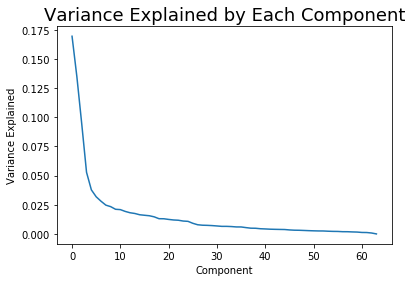

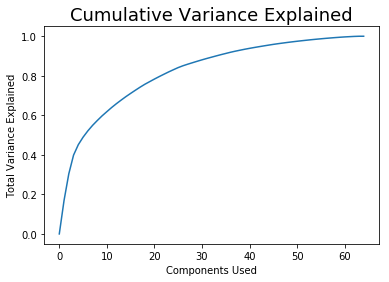

In [47]:
plt.figure();
plt.title('Variance Explained by Each Component', fontsize = 18);
plt.xlabel('Component');
plt.ylabel('Variance Explained');
plt.plot(pca.explained_variance_ratio_);

plt.figure();
plt.title('Cumulative Variance Explained', fontsize = 18);
plt.xlabel('Components Used');
plt.ylabel('Total Variance Explained');
plt.plot(cumulative_variance);

In [48]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 30)
X_pca = pca.fit_transform(X_scaled)

### Discussion 2.2: Perform Dimensionality Reduction
The number of components selected is 30.  With this number of components, the feature space can be reduced by more than half its original size while maintaining over 80% of the information contained in the original data as indicated by the cumulative variance curve.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [49]:
def map_weights_to_feats(weights, feat_names):
    
    weight_map = {feat_name: weight for feat_name, weight in zip(feat_names, weights)}
    weight_map = sorted(weight_map.items(), key = lambda x: x[1], reverse = True)
    weight_map = OrderedDict(weight_map)
    
    return weight_map
    

In [52]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

comp_1_weight_map = map_weights_to_feats(pca.components_[0], azdias.columns)
comp_1_weight_map

OrderedDict([('PLZ8_ANTG3', 0.22691610288902969),
             ('PLZ8_ANTG4', 0.22006414398527299),
             ('life_stage', 0.207770127840464),
             ('HH_EINKOMMEN_SCORE', 0.20440852576329216),
             ('ORTSGR_KLS9', 0.19764377027327004),
             ('EWDICHTE', 0.19588198584912786),
             ('FINANZ_HAUSBAUER', 0.16322185520979163),
             ('PLZ8_ANTG2', 0.15439949147627027),
             ('KBA05_ANTG4', 0.1532008857238224),
             ('FINANZ_SPARER', 0.14405056471329164),
             ('ARBEIT', 0.14397544356687036),
             ('ANZ_HAUSHALTE_AKTIV', 0.13593031112122272),
             ('RELAT_AB', 0.13568427278185888),
             ('KBA05_ANTG3', 0.13553681295644496),
             ('SEMIO_PFLICHT', 0.11267141005420964),
             ('SEMIO_REL', 0.10982221833490849),
             ('gen_movement', 0.10798384941898073),
             ('gen_by_decade', 0.099202722181637434),
             ('SEMIO_RAT', 0.092648281448913961),
             ('SEMIO_TRA

In [53]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp_2_weight_map = map_weights_to_feats(pca.components_[1], azdias.columns)
comp_2_weight_map

OrderedDict([('ALTERSKATEGORIE_GROB', 0.26066099013343103),
             ('FINANZ_VORSORGER', 0.23329106415255782),
             ('SEMIO_ERL', 0.23084940583396996),
             ('SEMIO_LUST', 0.18309120251366451),
             ('RETOURTYP_BK_S', 0.16412442351439441),
             ('W_KEIT_KIND_HH', 0.11849341001538589),
             ('SEMIO_KRIT', 0.1163636612528491),
             ('FINANZ_HAUSBAUER', 0.11464466305625808),
             ('SEMIO_KAEM', 0.11143777681779035),
             ('PLZ8_ANTG3', 0.090982745914284666),
             ('ANREDE_KZ', 0.089832225401520471),
             ('EWDICHTE', 0.08954703056400834),
             ('ORTSGR_KLS9', 0.088109001186034167),
             ('PLZ8_ANTG4', 0.086844740512115617),
             ('life_stage', 0.07174842828320524),
             ('SEMIO_DOM', 0.069345165682701257),
             ('FINANZ_MINIMALIST', 0.068708650578587716),
             ('KBA05_ANTG4', 0.067329122345160072),
             ('ARBEIT', 0.065403147164109554),
             

In [54]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp_3_weight_map = map_weights_to_feats(pca.components_[2], azdias.columns)
comp_3_weight_map

OrderedDict([('SEMIO_VERT', 0.34630166874585278),
             ('SEMIO_SOZ', 0.26344030474589264),
             ('SEMIO_FAM', 0.25018348223444642),
             ('SEMIO_KULT', 0.23431781880370264),
             ('FINANZ_MINIMALIST', 0.15629192443683848),
             ('RETOURTYP_BK_S', 0.1087866467979814),
             ('FINANZ_VORSORGER', 0.10035689784597192),
             ('W_KEIT_KIND_HH', 0.090579519429156929),
             ('ALTERSKATEGORIE_GROB', 0.078690495262549287),
             ('SEMIO_REL', 0.070223353744448977),
             ('SEMIO_LUST', 0.064149113379770334),
             ('SEMIO_MAT', 0.054811262679952739),
             ('GREEN_AVANTGARDE', 0.048381186605110482),
             ('ORTSGR_KLS9', 0.04683799377316334),
             ('EWDICHTE', 0.046316198160848747),
             ('PLZ8_ANTG4', 0.045667175122423749),
             ('PLZ8_ANTG3', 0.04527644069031312),
             ('ARBEIT', 0.034540150195685786),
             ('WOHNDAUER_2008', 0.032810951971171586),
         

### Discussion 2.3: Interpret Principal Components
For the first PC, PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_ANTG1, and MOBI_REGIO have the largest absolute weight values indicating that these features explain the most variation for PC1.  The signs of the coefficients suggest that the  PLZ8_ANTG3 and PLZ8_ANTG4 negatively correlate with PLZ8_ANTG1 and MOBI_REGIO but each feature positively correlates with the other in its pair. 

The features in PC2 that explain the most data variation are ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, gen_by_decade, and SEMIO_REL and the signs of the weights indicate that ALTERSKATEGORIE_GROB and FINANZ_VORSORGER posively correlate with each other but negatively correlate with gen_by_decade and SEMIO_REL. Also, gen_by_decade and SEMIO_REL correlate positively.

Finally, the PC3 features SEMIO_VERT, SEMIO_SOZ, SEMIO_KAEM, and ANREDE_KZ explain the most variation.  The signs of the weights can be interpretted such that the pair SEMIO_VERT and SEMIO_SOZ correlate positively and so does the pair SEMIO_KAEM and ANREDE_KZ but each pair corrleates negatviely with each other. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [88]:
def calculate_average_distance(X, model):
    
    n_observations = X.shape[0]
    distance = 0
    
    for i in range(n_observations):
        
        x = X[i, :]
        x_label = model.labels_[i]
        x_center = model.cluster_centers_[x_label]
        
        distance_squared = np.sum((x - x_center)**2)
        distance += np.sqrt(distance_squared)
    
    avg_distance = distance / n_observations
    
    return avg_distance       

In [52]:
avg_differences = []

for k in range(2, 31):
    
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X_pca)
    
    avg_difference = -kmeans.score(X_pca) / X_pca.shape[0]
    avg_differences.append(avg_difference) 
    
    print(f'Completed the {k} cluster model.')
    print(f'Average distance was {avg_difference}\n')

Completed the 2 cluster model.
Average distance was 48.18603063157411

Completed the 3 cluster model.
Average distance was 44.05632454243328

Completed the 4 cluster model.
Average distance was 41.43574762889989

Completed the 5 cluster model.
Average distance was 39.60699357112816

Completed the 6 cluster model.
Average distance was 38.02044107695494

Completed the 7 cluster model.
Average distance was 36.61372301232829

Completed the 8 cluster model.
Average distance was 35.529796027607325

Completed the 9 cluster model.
Average distance was 34.78159771867706

Completed the 10 cluster model.
Average distance was 34.05700320232773

Completed the 11 cluster model.
Average distance was 33.315659083612154

Completed the 12 cluster model.
Average distance was 32.59863578007646

Completed the 13 cluster model.
Average distance was 31.785308883567556

Completed the 14 cluster model.
Average distance was 31.79483846128536

Completed the 15 cluster model.
Average distance was 31.0721186646114

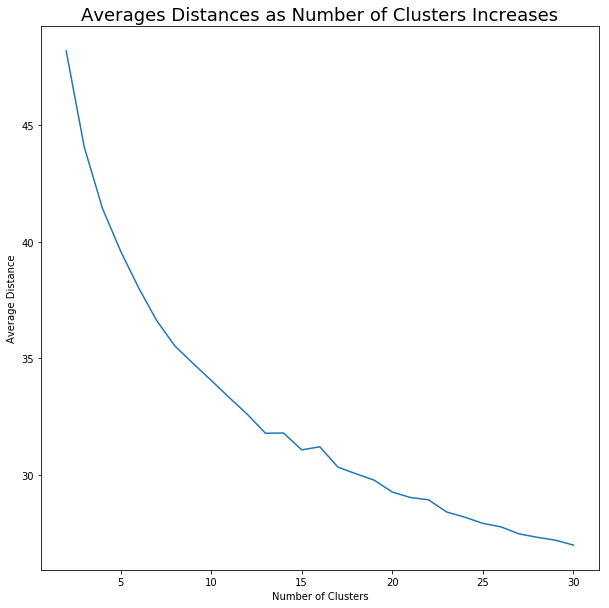

In [53]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize = (10, 10));
plt.plot(range(2, 31), avg_differences);
plt.title('Averages Distances as Number of Clusters Increases', fontsize = 18);
plt.xlabel('Number of Clusters');
plt.ylabel('Average Distance');

In [54]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 15).fit(X_pca)

### Discussion 3.1: Apply Clustering to General Population
According to the elbow plot given above, the rate at which the average distance decreases with respect to the cluster number begins to decrease dramatically after 15 clusters were used on the population.  Clusters added beyond this point are likely to overfit the data rather than provide a more accurate model. Therefore, the population has been segmented into 15 clusters in the final model.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [89]:
# Load in the customer demographics data.
customers = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [90]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers = clean_data(customers)

X_customers = imputer.transform(customers)
X_scaled_customers = scaler.transform(X_customers)
X_pca_customers = pca.transform(X_scaled_customers)

customer_labels = kmeans.predict(X_pca_customers)

In [91]:
population_labels = kmeans.predict(X_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [92]:
counts_customer = Counter(customer_labels)
n_customers = X_pca_customers.shape[0]

customer_freqs = {label: 100*(freq / n_customers) for label, freq in counts_customer.items()}

In [93]:
counts_population = Counter(population_labels)
n_population = X_pca.shape[0]

population_freqs = {label: 100*(freq / n_population) for label, freq in counts_population.items()}

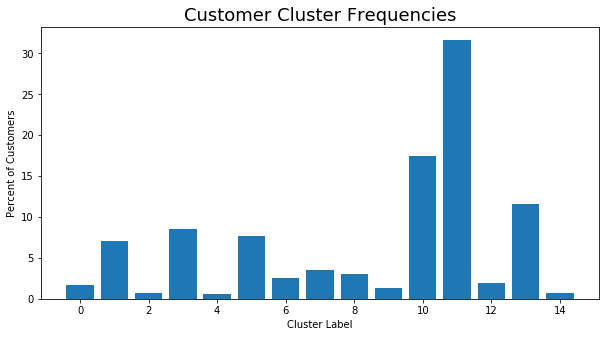

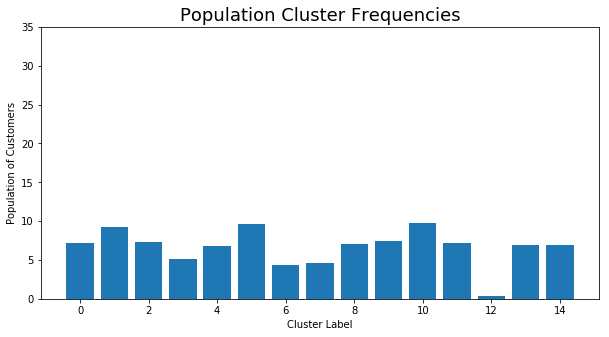

In [94]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
plt.figure(figsize = (10, 5));
plt.bar(customer_freqs.keys(), customer_freqs.values());
plt.title('Customer Cluster Frequencies', fontsize = 18);
plt.xlabel('Cluster Label');
plt.ylabel('Percent of Customers');

plt.figure(figsize = (10, 5));
plt.bar(population_freqs.keys(), population_freqs.values());
plt.title('Population Cluster Frequencies', fontsize = 18);
plt.xlabel('Cluster Label');
plt.ylabel('Population of Customers');
plt.ylim(bottom = 0, top = 35);


In [112]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

print(f'Proportion of general population in cluster 11: {population_freqs[11]}%')
print(f'Proportion of customer population in cluster 11: {customer_freqs[11]}%\n')


pc1_avg = (X_pca[population_labels == 11][:, 0].sum() + X_pca_customers[customer_labels == 11][:, 0].sum()) / \
          (n_population + n_customers)

pc2_avg = (X_pca[population_labels == 11][:, 1].sum() + X_pca_customers[customer_labels == 11][:, 1].sum()) / \
          (n_population + n_customers)

pc3_avg = (X_pca[population_labels == 11][:, 2].sum() + X_pca_customers[customer_labels == 11][:, 2].sum()) / \
          (n_population + n_customers)

print(f'The average first three PC\'s for the individuals in cluster 11 are {pc1_avg}, {pc2_avg}, and \n{pc3_avg}.' )

Proportion of general population in cluster 11: 7.123346317965836%
Proportion of customer population in cluster 11: 31.65789397992349%

The average first three PC's for the individuals in cluster 11 are -0.39247197733832234, 0.0129760160676945, and 
0.30785081014959287.


In [111]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

print(f'Proportion of general population in cluster 11: {population_freqs[2]}%')
print(f'Proportion of customer population in cluster 11: {customer_freqs[2]}%\n')

pc1_avg = (X_pca[population_labels == 2][:, 0].sum() + X_pca_customers[customer_labels == 2][:, 0].sum()) / \
          (n_population + n_customers)

pc2_avg = (X_pca[population_labels == 2][:, 1].sum() + X_pca_customers[customer_labels == 2][:, 1].sum()) / \
          (n_population + n_customers)

pc3_avg = (X_pca[population_labels == 2][:, 2].sum() + X_pca_customers[customer_labels == 2][:, 2].sum()) / \
          (n_population + n_customers)

print(f'The average first three PC\'s for the individuals in cluster 2 are {pc1_avg}, {pc2_avg}, and \n{pc3_avg}.' )

Proportion of general population in cluster 11: 7.355480271177576%
Proportion of customer population in cluster 11: 0.6917479218799436%

The average first three PC's for the individuals in cluster 2 are 0.11558578240291269, -0.12093482358208743, and 
-0.18644881599508795.


### Discussion 3.3: Compare Customer Data to Demographics Data
The cluster distributions for the general and customer populations indicate that cluster 11 is overrepresented in the customer population.  It was shown that the proportion of customers in cluster 11 is over four times greater than the proportion of the general population in cluster 11.  The average value for PC1 for these two groups was a negative.  Since PC1 is dominated by information pertaining to the size of the homes in the region the individuals live as well as their movement patterns, its value indicates that people who live in smaller homes with low movement form a large customer base.  The PC2 average was a positive value.  This component encapsulates information pertaining to the age and financial orientation of the inviduals which suggests the company's customers tend to be older with lower concerns for being financially prepared.  The PC3 average was also positive.  This component is dominated by information pertaining primarily to the personalty typology and this PC3 average suggests that the customers tend to be males who are not dreamful and socially minded but more combative in attitude.  

The cluster distributions also indicate that cluster 2 is underrepresented in the customer population.  It was shown that the proportion of people in cluster 2 for the general population is over 10 times that for the customer population. For cluster 2, note that the signs of the PC averages are opposite of those for cluster 11.  This indicates that inviduals with the opposite characteristics of those in cluster 11 are unlikely to be customers of the mail order company.



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.